# Embeddings in external spaces
## Init

In [1]:
%load_ext autoreload
%autoreload 2
%env https_proxy=http://proxy:80
%env http_proxy=http://proxy:80

from inversion.utils import *
from inversion.clip_utils import *
from inversion.reconstruction import *
import matplotlib.pyplot as plt
from torch.functional import F
import os
import numpy as np
import torch
from tqdm import tqdm

import pandas as pd
from scipy.spatial.distance import cdist


env: https_proxy=http://proxy:80
env: http_proxy=http://proxy:80


/home/woody/iwi1/iwi1106h/software/private/conda/envs/bube/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
# Load the individual components of Stable Diffusion
diffusion_model_name = "CompVis/stable-diffusion-v1-4"
clip_model_name = "openai/clip-vit-large-patch14"

clip_suite = CLIPSuite(diffusion_model_name, clip_model_name)
# Define all available torch network initializers
def init_networks(no_relu):
    global networks
    print(f"initing networks with{'out' if no_relu else ''} ReLU")
    networks = {
        'resnet18': init_torch_resnet18(no_relu=no_relu),
        'resnet34': init_torch_resnet34(no_relu=no_relu),
        'resnet50': init_torch_resnet50(no_relu=no_relu),
        'resnet101': init_torch_resnet101(no_relu=no_relu),
        'resnet152': init_torch_resnet152(no_relu=no_relu),
        'vgg16': init_torch_vgg16(no_relu=no_relu),
        'vgg19': init_torch_vgg19(no_relu=no_relu),
        'clip': lambda x: clip_suite.image_projector()(x).image_embeds,
    }

    return networks

networks = init_networks(no_relu=True)

distance = {
    network_name: F.mse_loss for network_name in networks.keys()
}
distance['clip'] = lambda x,y : 1 - F.cosine_similarity(x, y).mean()

distance_name = {
    network_name: 'MSE' for network_name in networks.keys()
}
distance_name['clip'] = '1 - cosine similarity'

display_name = {
    'resnet18': 'ResNet-18',
    'resnet34': 'ResNet-34',
    'resnet50': 'ResNet-50',
    'resnet101': 'ResNet-101',
    'resnet152': 'ResNet-152',
    'vgg16': 'VGG-16',
    'vgg19': 'VGG-19',
    'clip': 'CLIP',
}

combined_file = 'embeddings/all_networks_embeddings.npz'

initing networks without ReLU


## ImageNet images

In [3]:
# only execute if combined_file does not exist
if not os.path.exists(combined_file):
    train_loader, val_loader = get_imagenet_loader(batch_size=256, resolution=224)
    plot(denormalize(next(iter(train_loader))[0][:4]))
    # Create directory for embeddings if it doesn't exist
    os.makedirs('embeddings', exist_ok=True)

    # Dictionary to store all embeddings from all networks
    all_network_embeddings = {}
    all_labels = None  # Labels will be the same for all networks

    embeds = {
        'resnet18': [],
        'resnet34': [],
        'resnet50': [],
        'resnet101': [],
        'resnet152': [],
        'vgg16': [],
        'vgg19': [],
        'clip': [],
    }
    lbls = {
        'resnet18': [],
        'resnet34': [],
        'resnet50': [],
        'resnet101': [],
        'resnet152': [],
        'vgg16': [],
        'vgg19': [],
        'clip': [],
    }

        
        # Process validation set
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(val_loader, desc=f"Computing embeddings")):
            # Move to GPU if available
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            images = images.to(device)
            labels = labels.numpy()
            # Loop through each network
            for network_name, model in networks.items():
                
                # Get embeddings
                embeddings = model(images)
                
                # Move back to CPU and convert to numpy
                embeddings = embeddings.cpu().numpy()
                
                # Store embeddings and labels
                embeds[network_name].append(embeddings)
                lbls[network_name].extend(labels)
                # Optional: limit processing for testing (remove this line for full dataset)
                #if batch_idx >= 10:  # Process only first 10 batches for testing
                #    break
        
        # Concatenate all embeddings for this network
        for network_name, model in networks.items():
            network_embeddings = np.concatenate(embeds[network_name], axis=0)
            network_labels = np.array(lbls[network_name])
            
            # Store in the main dictionary
            all_network_embeddings[network_name] = network_embeddings
            
            # Store labels (same for all networks, so we only need to do this once)
            if all_labels is None:
                all_labels = network_labels
            
            print(f"Processed {network_name} embeddings: {network_embeddings.shape}")
            
            # Clear memory
            del model
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

    # Save all embeddings and labels to a single file
    print("\nSaving all embeddings to a single file...")
    np.savez_compressed(combined_file, labels=all_labels, **all_network_embeddings)

    print(f"\nAll embeddings saved to: {combined_file}")
    print("File contains:")
    print(f"- labels: {all_labels.shape}")
    for network_name, embeddings in all_network_embeddings.items():
        print(f"- {network_name}: {embeddings.shape}")

    print("\nTo load the data later, use:")
    print("data = np.load('embeddings/all_networks_embeddings.npz')")
    print("labels = data['labels']")
    print("resnet_embeddings = data['resnet']")
    print("# etc. for other networks")

In [4]:
# Load the embeddings data
data = np.load(combined_file)

# Dictionary to store distances for each model
all_distances = {}

# Get the 42nd embedding for each model and calculate L2 distances
for network_name in networks.keys():
    # Get embeddings for this network
    network_embeddings = data[network_name]
    
    # Get the 42nd embedding (index 41)
    ref_embedding = network_embeddings[41:42]  # Keep as 2D array for cdist
    
    # Calculate mse loss
    noisy_distances = np.mean((ref_embedding - network_embeddings) ** 2, axis=1)

    # Store distances
    all_distances[network_name] = noisy_distances
    
    print(f"{network_name}: Calculated {len(noisy_distances)} distances")

# Create single dataframe with all distances
distance_df = pd.DataFrame({
    'embedding_index': range(len(data['labels'])),
    'label': data['labels'],
    **all_distances
})

print(f"\nCreated combined dataframe with shape: {distance_df.shape}")
print("\nFirst 10 rows:")
print(distance_df.head(10))

print(f"\nDistance from 42nd embedding to itself (should be 0.0):")
print(distance_df.iloc[41][['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'vgg16', 'vgg19', 'clip']])

resnet18: Calculated 50000 distances
resnet34: Calculated 50000 distances
resnet50: Calculated 50000 distances
resnet101: Calculated 50000 distances
resnet152: Calculated 50000 distances
vgg16: Calculated 50000 distances
vgg19: Calculated 50000 distances
clip: Calculated 50000 distances

Created combined dataframe with shape: (50000, 10)

First 10 rows:
   embedding_index  label  resnet18  resnet34  resnet50  resnet101  resnet152  \
0                0      0  1.500150  1.122838  0.253825   0.259583   0.266450   
1                1      0  1.237339  1.054672  0.220407   0.182930   0.207678   
2                2      0  1.198296  1.433909  0.249567   0.304289   0.291791   
3                3      0  0.518242  0.579899  0.128633   0.090058   0.114024   
4                4      0  1.231191  0.883185  0.223964   0.155096   0.178295   
5                5      0  1.501785  1.053958  0.183006   0.200570   0.152725   
6                6      0  0.674821  0.489176  0.074888   0.117916   0.112854

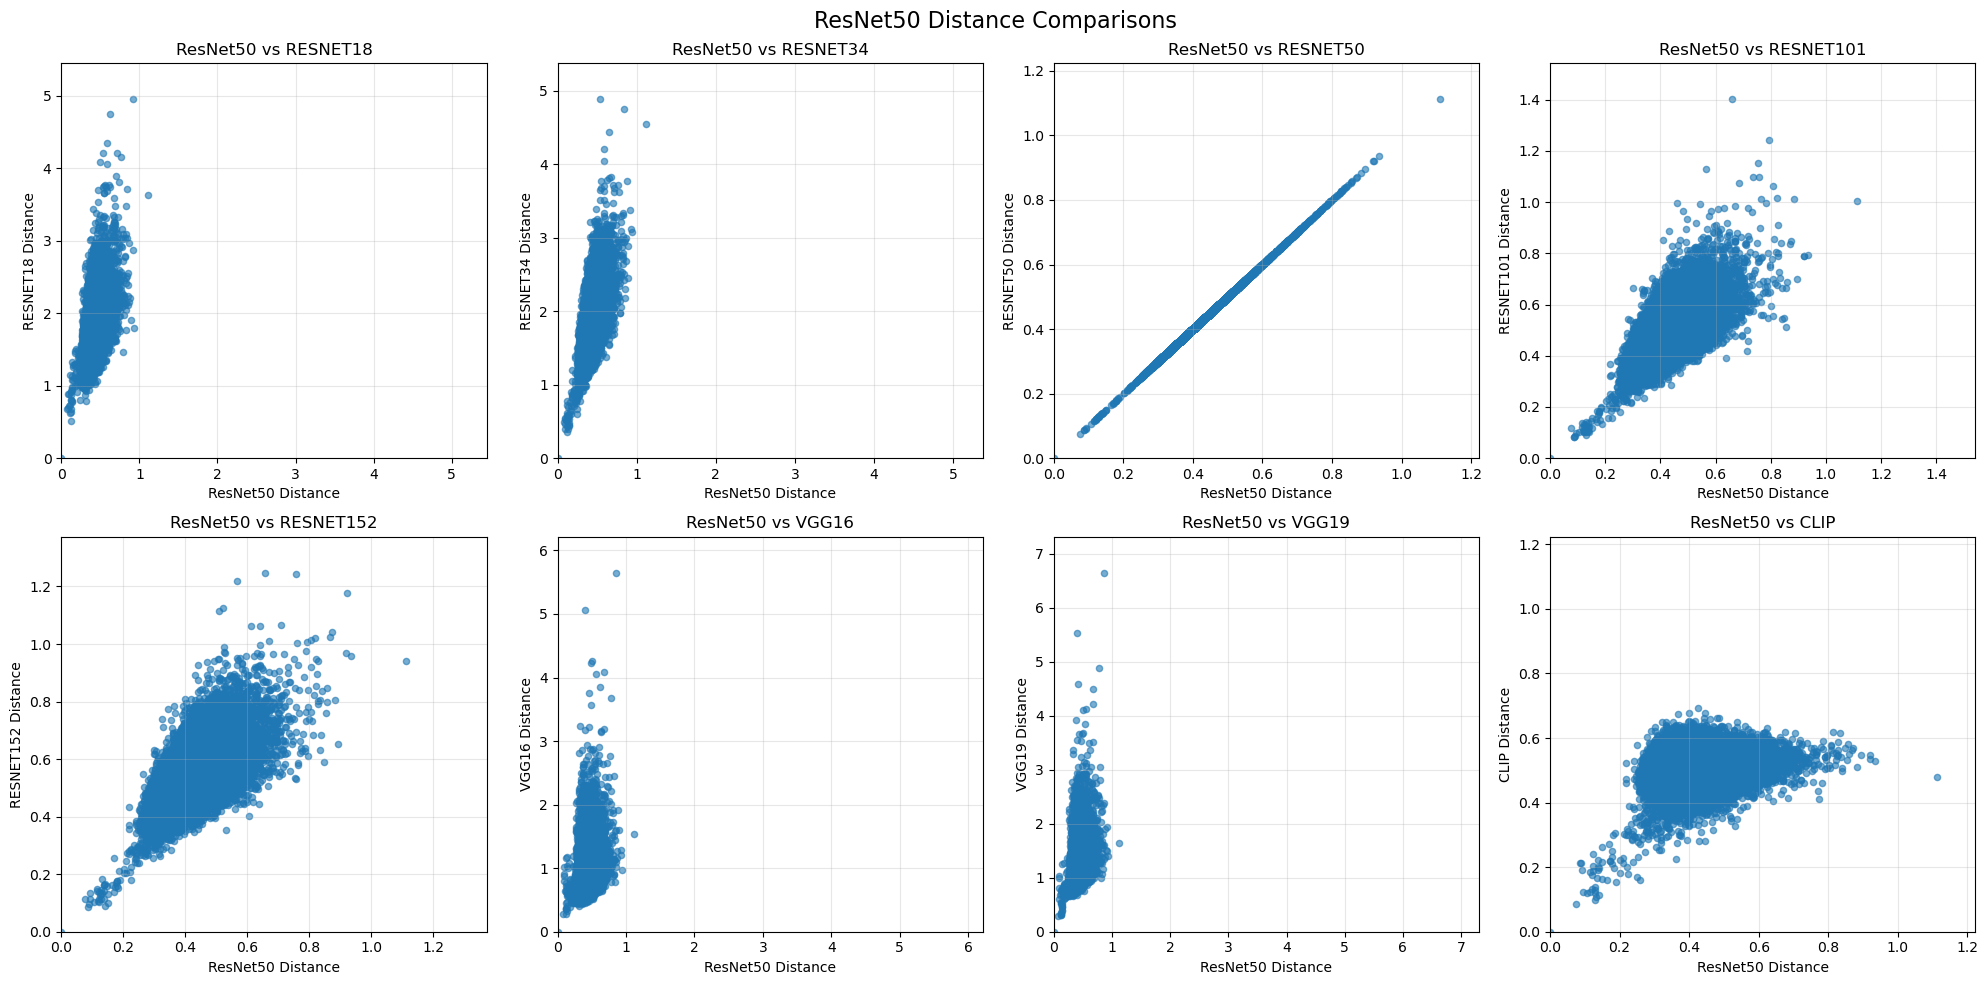

In [5]:
sample_size = len(distance_df) 
sampled_df = distance_df.sample(n=sample_size, random_state=42)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('ResNet50 Distance Comparisons', fontsize=16)

for i, model in enumerate(networks.keys()):
    row = i // 4
    col = i % 4
    
    scatter = axes[row, col].scatter(sampled_df['resnet50'], sampled_df[model], alpha=0.6, s=20)
    axes[row, col].set_xlabel('ResNet50 Distance')
    axes[row, col].set_ylabel(f'{model.upper()} Distance')
    axes[row, col].set_title(f'ResNet50 vs {model.upper()}')
    axes[row, col].grid(True, alpha=0.3)
    # Set equal axis limits that include (0,0)
    max_val = max(sampled_df['resnet50'].max(), sampled_df[model].max())
    axes[row, col].set_xlim(0, max_val * 1.1)
    axes[row, col].set_ylim(0, max_val * 1.1)
plt.tight_layout()
plt.show()

## Noisy images

In [4]:
#img_paths = ["Images/14042.jpg", "Images/14158.jpg", "Images/14034.jpg"]
img_path = "Images/14042.jpg"

img = clip_suite.get_preprocessed_images([img_path])
img_name = os.path.basename(img_path)

clean_embeddings = {}
noisy_embeddings = {}
noisy_distances = {}
distances = None

def calc_clean_embeddings():
    for network_name, model in networks.items():
        clean_embeddings[network_name] = model(img)

    for network_name, model in networks.items():
        clean_embeddings[network_name] = clean_embeddings[network_name].detach().cpu().numpy()

noise_levels = np.arange(0.03, 0.06, 0.001)
def calc_noised_embeddings():
    for network_name, model in networks.items():
        noisy_embeddings[network_name] = []
        noisy_distances[network_name] = []


    for (step, noise_percentage) in enumerate(tqdm(noise_levels, desc=f"Computing embeddings for noised")):
        noise = torch.randn_like(img) * noise_percentage
        noisy_img = img * (1-noise_percentage) + noise

        for network_name, model in networks.items():
            embedding = model(noisy_img)
            noisy_embeddings[network_name].append(embedding.detach())
            noisy_distances[network_name].append(distance[network_name](torch.tensor(clean_embeddings[network_name], device=embedding.device), embedding).item())

    for network_name, model in networks.items():
        noisy_embeddings[network_name] = torch.stack(noisy_embeddings[network_name]).cpu().numpy().reshape(-1, noisy_embeddings[network_name][0].shape[-1])
        noisy_distances[network_name] = np.array(noisy_distances[network_name])

calc_clean_embeddings()
calc_noised_embeddings()

Computing embeddings for noised: 100%|██████████| 30/30 [00:02<00:00, 12.40it/s]


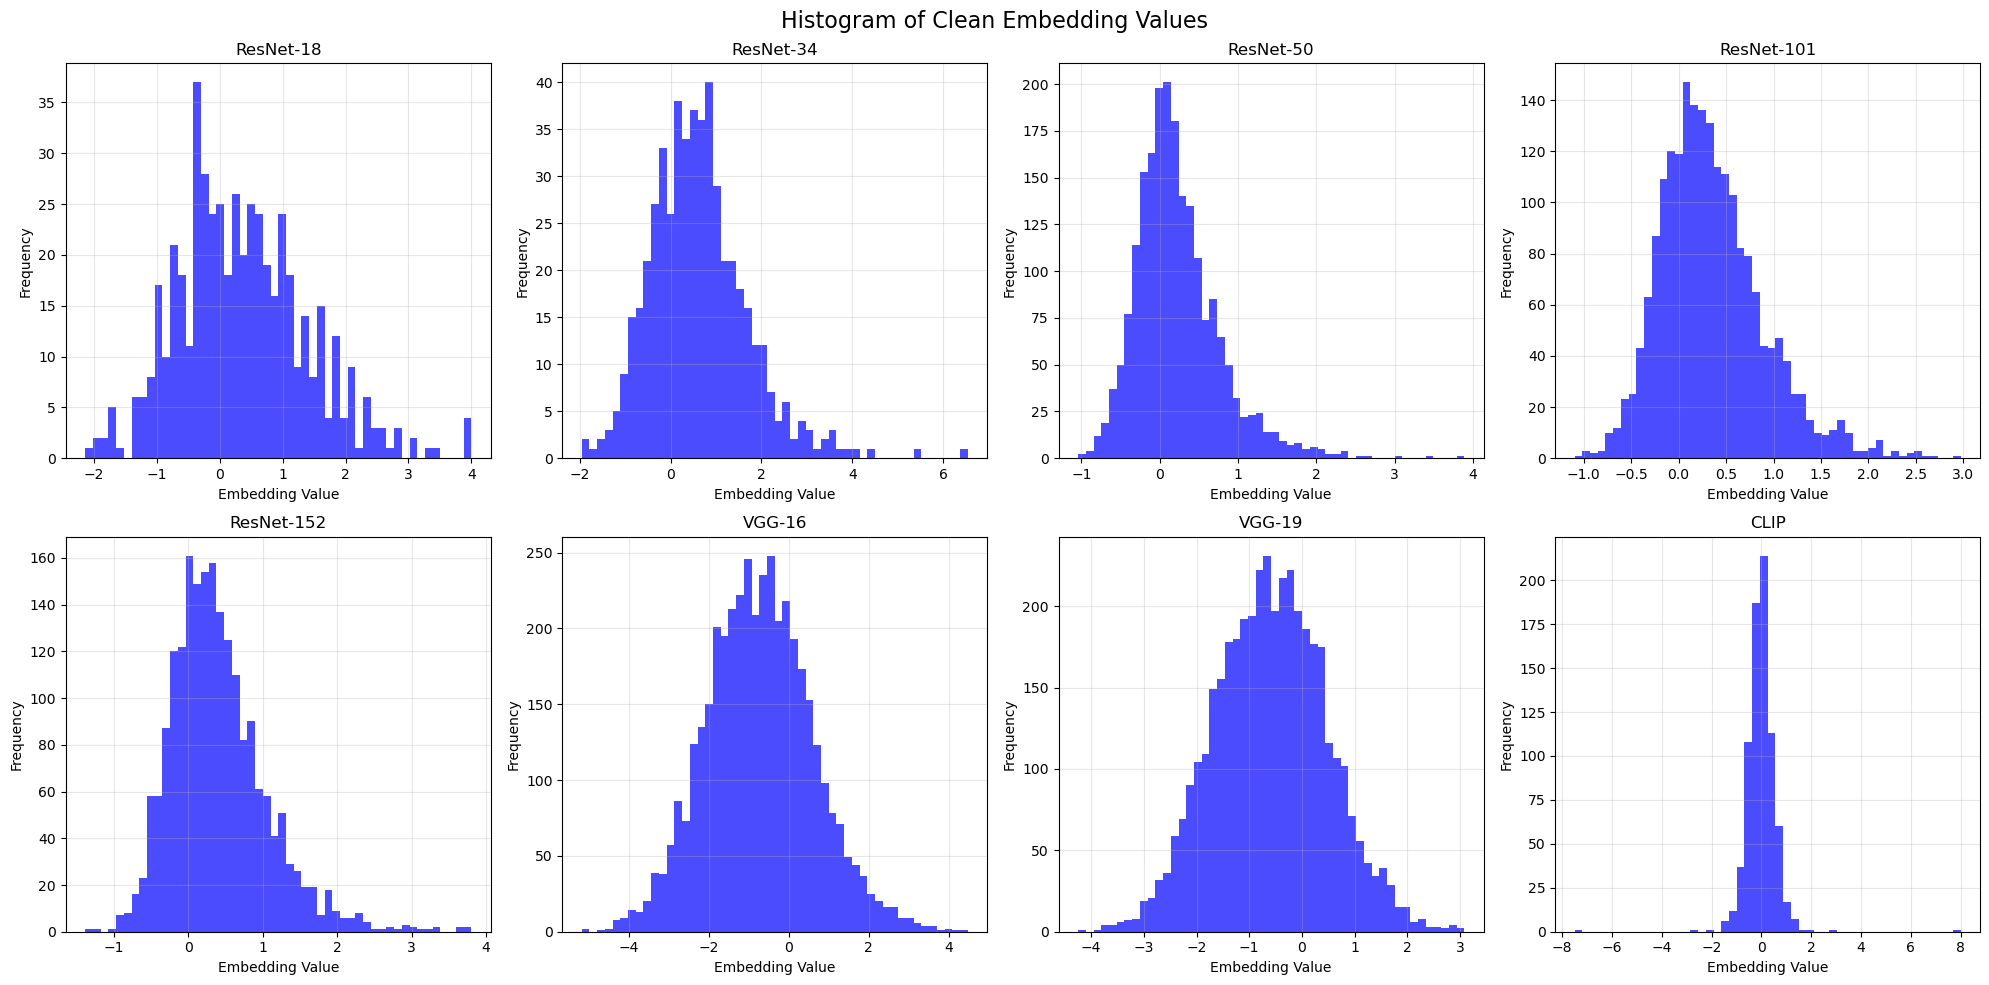

In [4]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Histogram of Clean Embedding Values', fontsize=16)

for i, (model, emb) in enumerate(clean_embeddings.items()):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    ax.hist(emb.flatten(), bins=50, alpha=0.7, color='blue')
    ax.set_title(display_name[model])
    ax.set_xlabel('Embedding Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
torch.cuda.empty_cache() if torch.cuda.is_available() else None

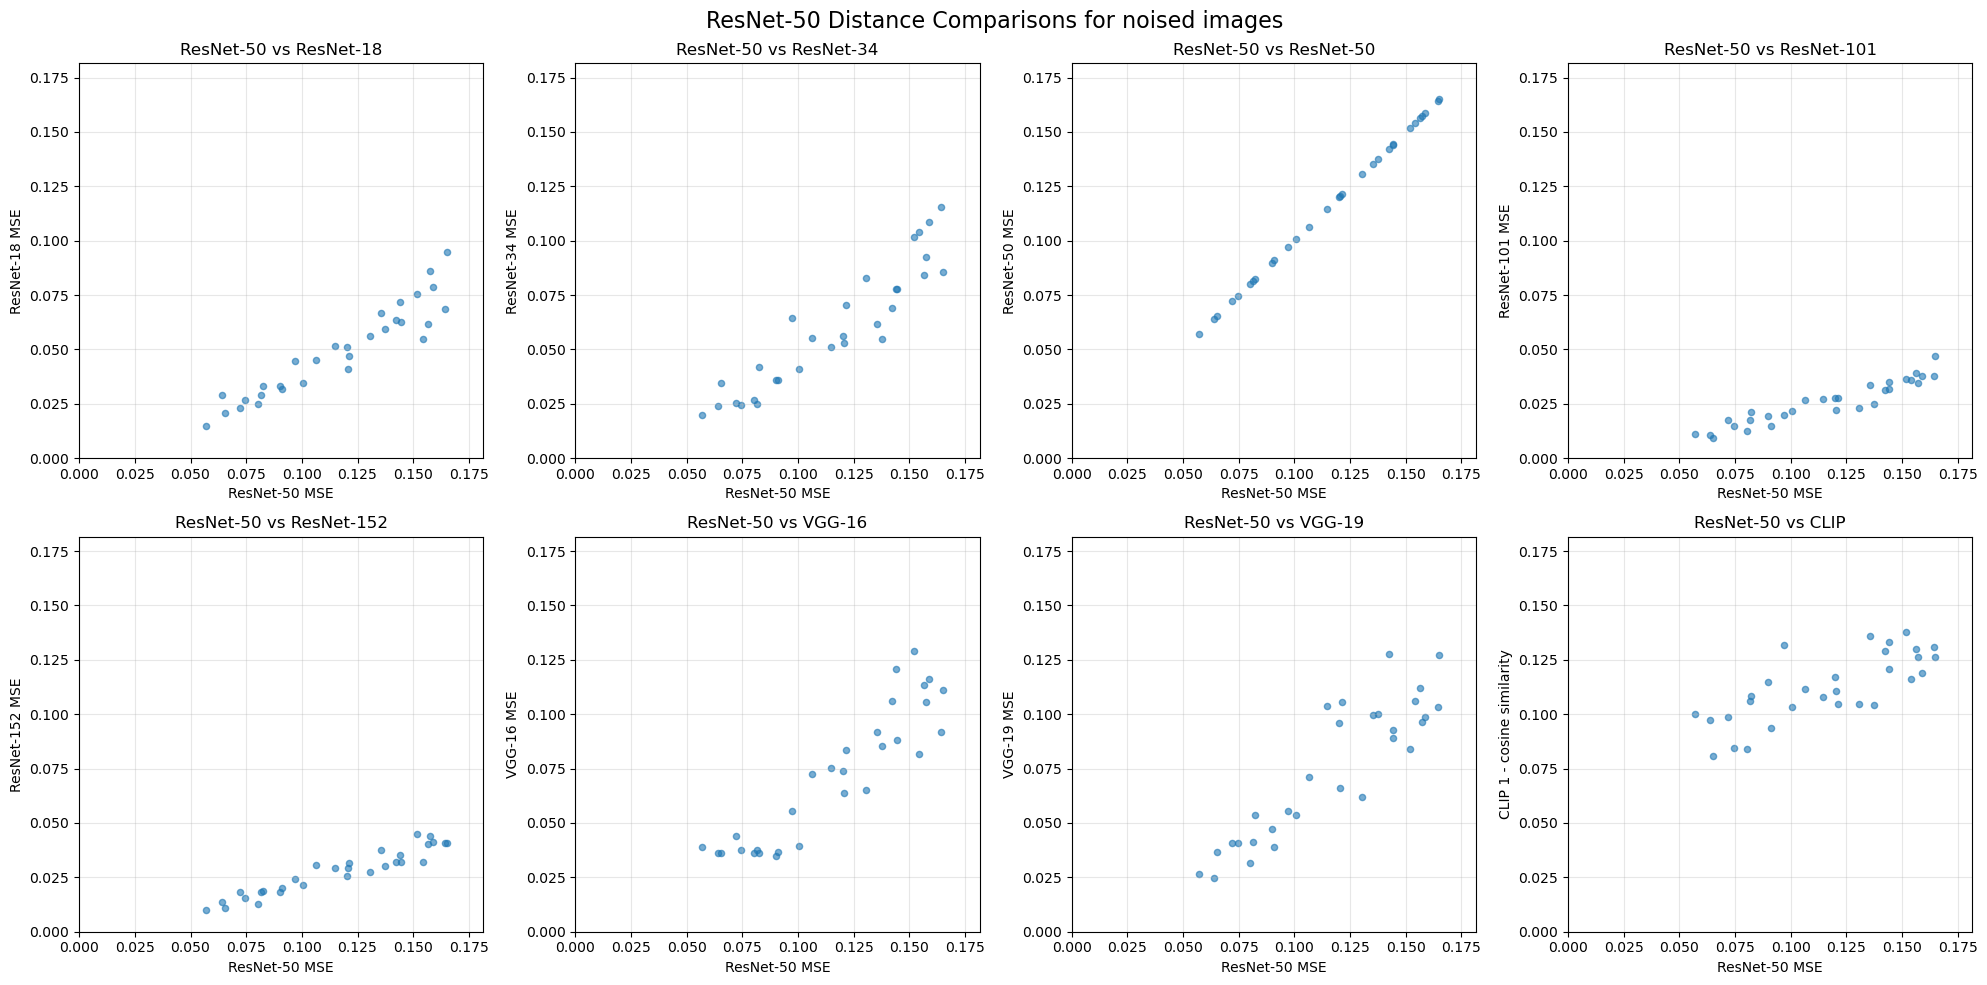

In [9]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle(f'{display_name["resnet50"]} Distance Comparisons for noised images', fontsize=16)

for i, model in enumerate(networks.keys()):
    row = i // 4
    col = i % 4
    
    scatter = axes[row, col].scatter(noisy_distances['resnet50'], noisy_distances[model], alpha=0.6, s=20)
    axes[row, col].set_xlabel(f'{display_name["resnet50"]} {distance_name["resnet50"]}')
    axes[row, col].set_ylabel(f'{display_name[model]} {distance_name[model]}')
    axes[row, col].set_title(f'{display_name["resnet50"]} vs {display_name[model]}')
    axes[row, col].grid(True, alpha=0.3)
    # Set equal axis limits that include (0,0)
    max_val = max(noisy_distances['resnet50'].max(), noisy_distances[model].max())
    axes[row, col].set_xlim(0, max_val * 1.1)
    axes[row, col].set_ylim(0, max_val * 1.1)
plt.tight_layout()
plt.show()

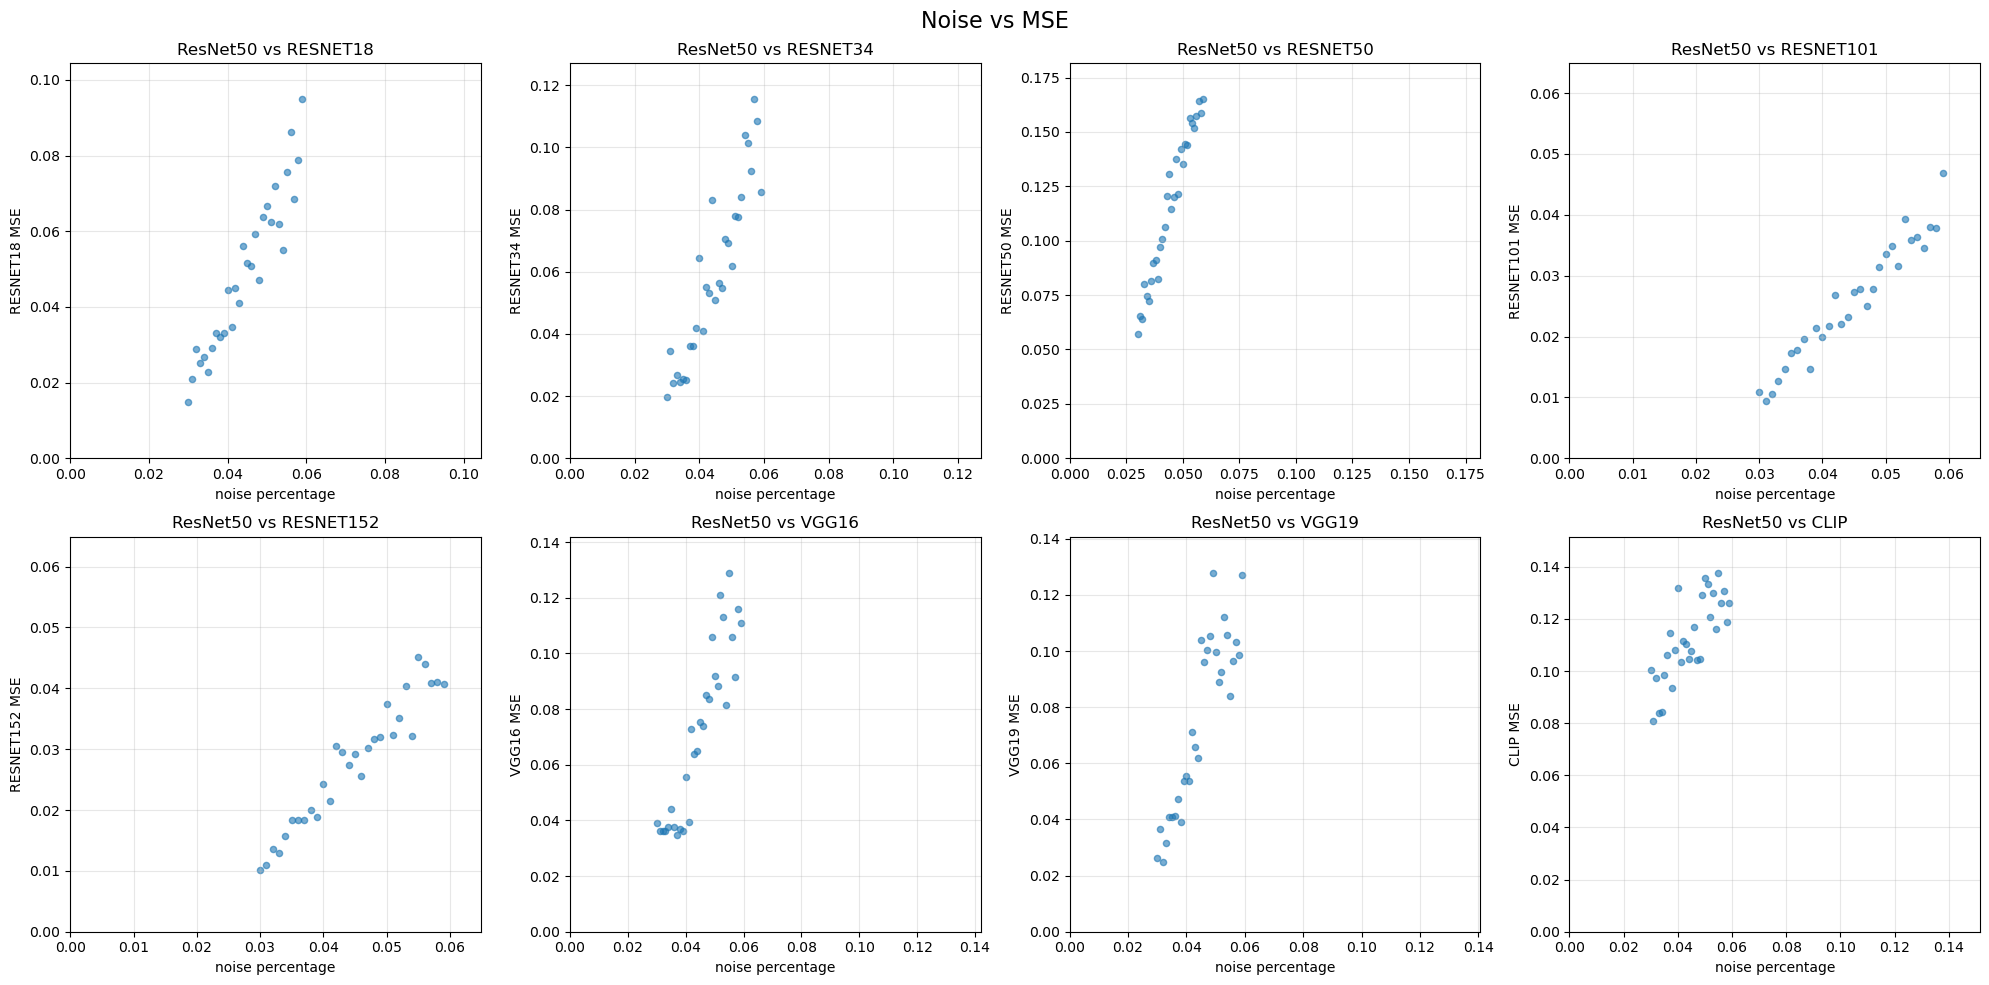

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Noise vs MSE', fontsize=16)

for i, model in enumerate(networks.keys()):
    row = i // 4
    col = i % 4
    
    scatter = axes[row, col].scatter(noise_levels, noisy_distances[model], alpha=0.6, s=20)
    axes[row, col].set_xlabel('noise percentage')
    axes[row, col].set_ylabel(f'{model.upper()} MSE')
    axes[row, col].set_title(f'ResNet50 vs {model.upper()}')
    axes[row, col].grid(True, alpha=0.3)
    # Set equal axis limits that include (0,0)
    max_val = max(noise_levels.max(), noisy_distances[model].max())
    axes[row, col].set_xlim(0, max_val * 1.1)
    axes[row, col].set_ylim(0, max_val * 1.1)
plt.tight_layout()
plt.show()

## Produce Reconstructions

In [5]:
reconstructions_file = "embeddings/reconstructions.pt"

if os.path.exists(reconstructions_file):
    reconstructions = torch.load(reconstructions_file)
else:
    config = RunConfig(
        loss_scale_rn=1.0,
        loss_scale_tv=1.0,
        loss_function_rn="mse",
        loss_function_tv="squared_relu",
        iterations=3000,
    )
    all_reconstructions = []
    num_runs = 1  # Number of reconstruction runs

    for run_idx in range(num_runs):
        recon = run_reconstructions(
            img_path=img_path,
            config=config,
            img_logging_freq=100,
            reconstructions_per_img=30,
            clip_suite=clip_suite,
            run_tags=["noise_correlation", "test"]
        )["reconstructions"]
        all_reconstructions.append(recon)

    reconstructions = torch.cat(all_reconstructions, dim=0)
    torch.save(reconstructions, reconstructions_file)


/tmp/ipykernel_543209/3405927267.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reconstructions = torch.load(reconstructions_file)


In [6]:
reconstruction_embeddings = {}
reconstruction_distances = {}
reconstruction_avgs = {}
reconstruction_avgs_half = {}

def calc_reconstruction_embeddings(limit=None):
    for network_name, model in networks.items():
        reconstruction_embeddings[network_name] =  []
        reconstruction_distances[network_name] = []


    for (recon_index, recon) in enumerate(tqdm(reconstructions, desc=f"Computing embeddings for reconstructions")):
        if limit is not None and recon_index >= limit:
            break
        for network_name, model in networks.items():
            recon_emb = model(recon.unsqueeze(0))
            embedding = recon_emb.squeeze().detach().cpu().numpy()
            reconstruction_embeddings[network_name].append(embedding)
            # Calculate MSE distance to clean embedding
            reconstruction_distances[network_name].append(((clean_embeddings[network_name] - embedding)**2).mean())

    for network_name, model in networks.items():
        reconstruction_embeddings[network_name] = np.array(reconstruction_embeddings[network_name])
        reconstruction_distances[network_name] = np.array(reconstruction_distances[network_name])
        reconstruction_avgs[network_name] = reconstruction_embeddings[network_name].mean(axis=0)
        reconstruction_avgs_half[network_name] = reconstruction_embeddings[network_name][:len(reconstruction_embeddings[network_name]) // 2].mean(axis=0)

calc_reconstruction_embeddings()

Computing embeddings for reconstructions:   7%|▋         | 2/30 [00:00<00:01, 14.01it/s]

Computing embeddings for reconstructions: 100%|██████████| 30/30 [00:02<00:00, 14.36it/s]


## Plotting with reconstructions

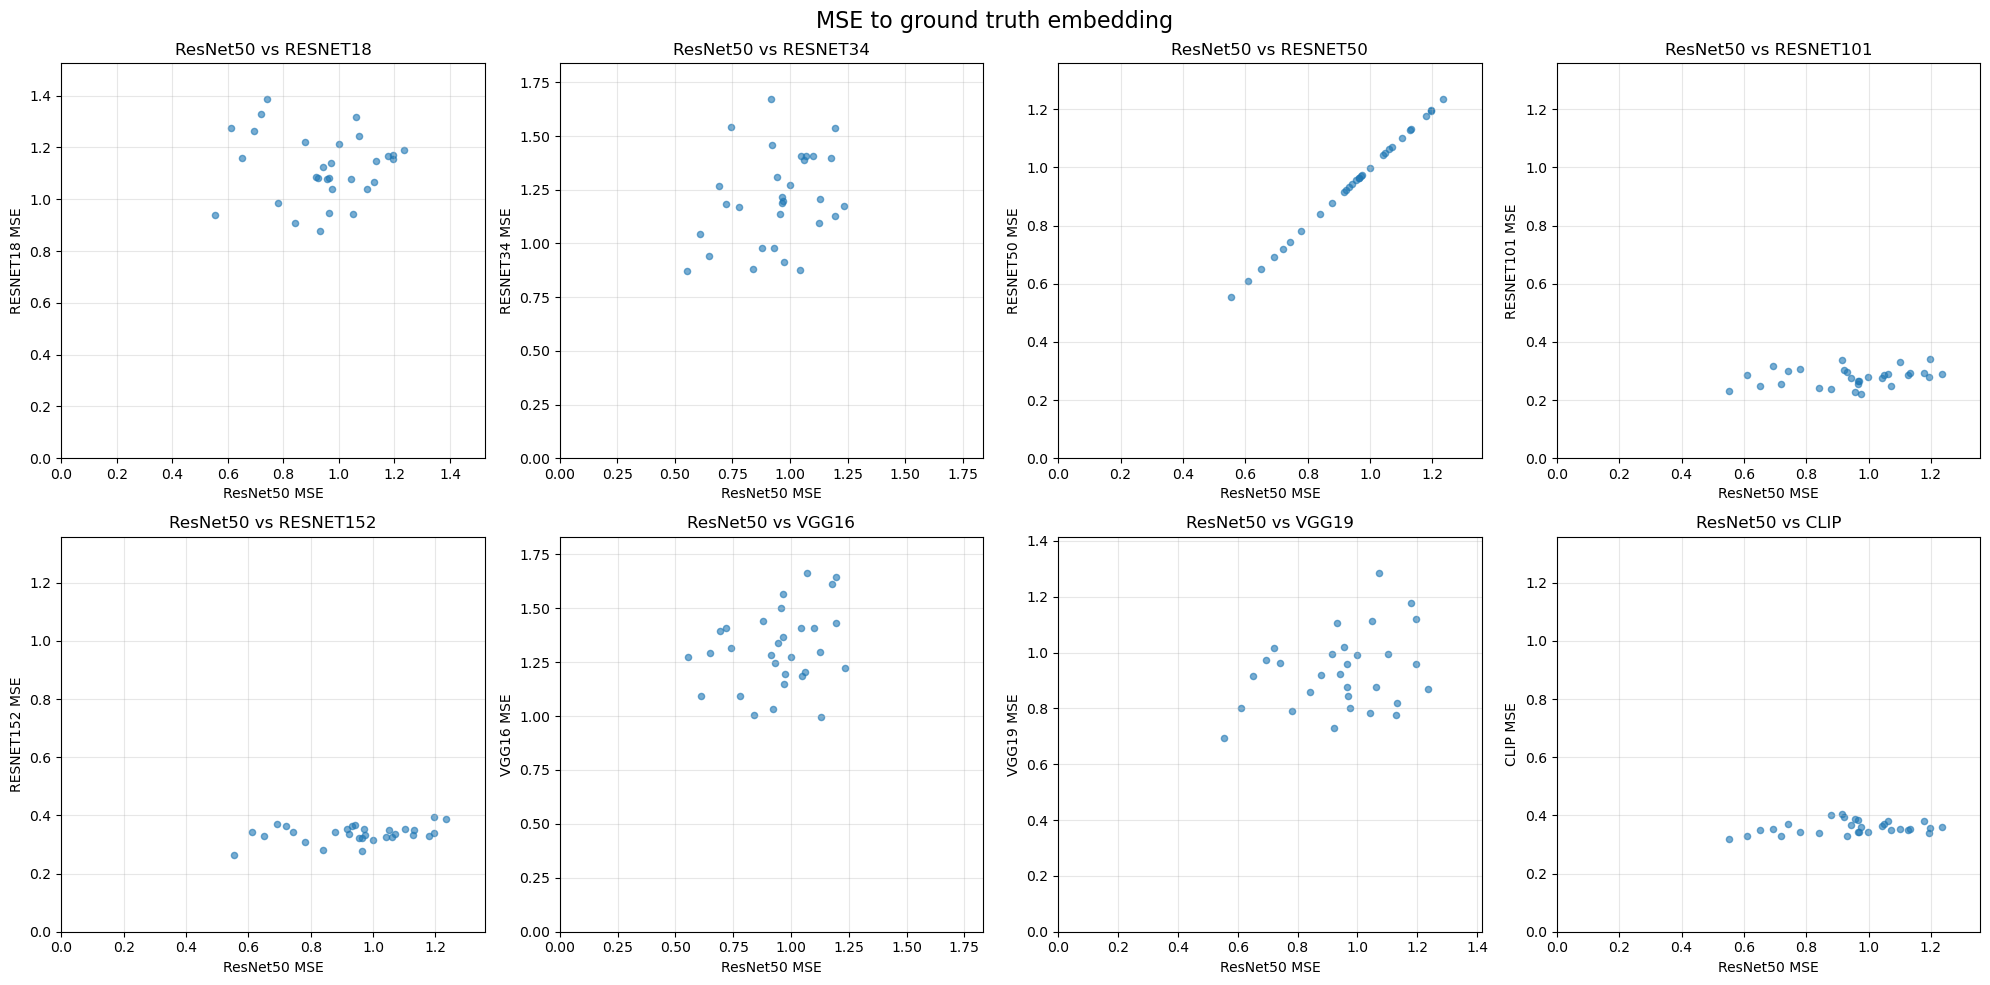

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('MSE to ground truth embedding', fontsize=16)

for i, model in enumerate(networks.keys()):
    row = i // 4
    col = i % 4

    scatter = axes[row, col].scatter(reconstruction_distances['resnet50'], reconstruction_distances[model], alpha=0.6, s=20)
    axes[row, col].set_xlabel('ResNet50 MSE')
    axes[row, col].set_ylabel(f'{model.upper()} MSE')
    axes[row, col].set_title(f'ResNet50 vs {model.upper()}')
    axes[row, col].grid(True, alpha=0.3)
    # Set equal axis limits that include (0,0)
    max_val = max(reconstruction_distances['resnet50'].max(), reconstruction_distances[model].max())
    axes[row, col].set_xlim(0, max_val * 1.1)
    axes[row, col].set_ylim(0, max_val * 1.1)
plt.tight_layout()
plt.show()

### Dimensionality reduction

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Dictionary to store PCA models and projections
pca_models = {}
noisy_embeddings_2d = {}
noisy_embeddings_filtered = {}
reconstruction_embeddings_2d = {}
clean_embeddings_2d = {}
    
max_dist = reconstruction_distances['resnet50'].max()
min_dist = reconstruction_distances['resnet50'].min()

for network_name in networks.keys():
    noisy_embeddings_filtered[network_name] = np.array(noisy_embeddings[network_name])[(noisy_distances[network_name] < max_dist) & (noisy_distances[network_name] > min_dist)]

for network_name in networks.keys():
    # Fit PCA with 2 components
    pca = TSNE(n_components=2, random_state=42)
    #pca = PCA(n_components=2)
    pca_models[network_name] = pca
    
    # Project noisy embeddings to 2D
    arr = pca.fit_transform(np.concatenate([noisy_embeddings_filtered[network_name], reconstruction_embeddings[network_name], reconstruction_embeddings[network_name]], axis=0))
    noisy_embeddings_2d[network_name] = arr[:noisy_embeddings_filtered[network_name].shape[0]]
    clean_embeddings_2d[network_name] = arr[-1:]
    
    # Project reconstruction embeddings to 2D using the same PCA
    reconstruction_embeddings_2d[network_name] = arr[noisy_embeddings_filtered[network_name].shape[0]:-1]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('MSE to ground truth embedding', fontsize=16)

for i, model in enumerate(networks.keys()):
    row = i // 4
    col = i % 4

    axes[row, col].scatter(noisy_embeddings_2d[model][:, 0], noisy_embeddings_2d[model][:, 1], alpha=0.6, s=20)
    axes[row, col].scatter(reconstruction_embeddings_2d[model][:, 0], reconstruction_embeddings_2d[model][:, 1], alpha=0.6, s=20)
    axes[row, col].scatter(clean_embeddings_2d[model][:, 0], clean_embeddings_2d[model][:, 1], color='red', s=100, marker='x', label='Average', zorder=5)
    axes[row, col].set_xlabel('ResNet50 MSE')
    axes[row, col].set_ylabel(f'{model.upper()} MSE')
    axes[row, col].set_title(f'ResNet50 vs {model.upper()}')
    axes[row, col].grid(True, alpha=0.3)
    # Set equal axis limits that include (0,0)
    max_val = max(noisy_embeddings_2d[model].max(), reconstruction_embeddings_2d[model].max())
    min_val = min(noisy_embeddings_2d[model].min(), reconstruction_embeddings_2d[model].min())
    axes[row, col].set_xlim(min_val * 1.1, max_val * 1.1)
    axes[row, col].set_ylim(min_val * 1.1, max_val * 1.1)
plt.tight_layout()
plt.show()

IndexError: boolean index did not match indexed array along axis 0; size of axis is 430080 but size of corresponding boolean axis is 30

### Averages

initing networks with ReLU


Computing embeddings for noised: 100%|██████████| 30/30 [00:02<00:00, 14.08it/s]


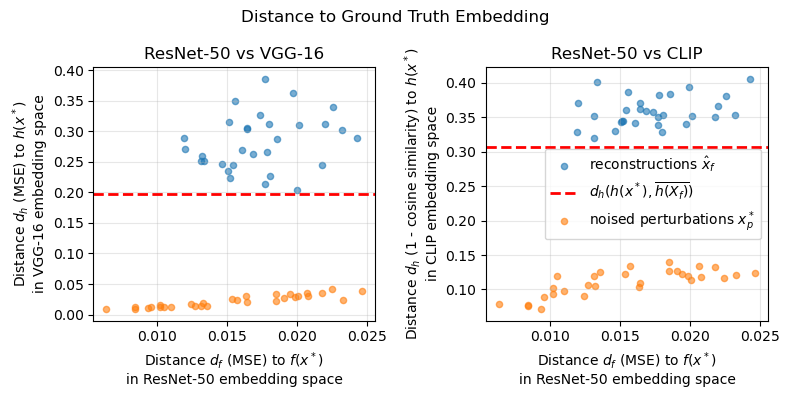

In [7]:
# The figure in the documentation
networks = init_networks(False)
calc_clean_embeddings()
calc_reconstruction_embeddings()
calc_noised_embeddings()

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Distance to Ground Truth Embedding', fontsize=12)

resnet_avg_dist = ((clean_embeddings['resnet50'] - reconstruction_avgs['resnet50'])**2).mean()
for i, model in enumerate(['vgg16', 'clip']):
    col = i % 2

    
    averaged_distance = ((clean_embeddings[model] - reconstruction_avgs[model])**2).mean()
    axes[col].set_xlabel(r"Distance $d_f$ ("+ f'{distance_name["resnet50"]}' + r") to $f(x^*)$" + f'\nin {display_name["resnet50"]} embedding space')
    axes[col].set_ylabel(r"Distance $d_h$ ("+ f'{distance_name[model]}' + r") to $h(x^*)$" + f'\nin {display_name[model]} embedding space')
    axes[col].set_title(f'{display_name["resnet50"]} vs {display_name[model]}')
    max_val = max(
        noisy_distances['resnet50'].max(),
        noisy_distances[model].max(),
        reconstruction_distances['resnet50'].max(),
        reconstruction_distances[model].max(),
        )
    axes[col].grid(True, alpha=0.3)
    axes[col].set_xticks(np.arange(0, max_val * 1.1, 0.005))
    axes[col].set_yticks(np.arange(0, max_val * 1.1, 0.05))

    axes[col].scatter(reconstruction_distances['resnet50'], reconstruction_distances[model], alpha=0.6, s=20, label=r"reconstructions $\hat{x}_f$")
    axes[col].axhline(averaged_distance, color='red', linestyle='--', linewidth=2, label=r'$d_h(h(x^*),\overline{h(X_f)})$')
    axes[col].scatter(noisy_distances['resnet50'], noisy_distances[model], alpha=0.6, s=20, label=r"noised perturbations $x^*_p$")

plt.legend()
plt.tight_layout()
plt.show()

fig.savefig('out/figures/avg-distance-scatter.pdf', bbox_inches='tight')


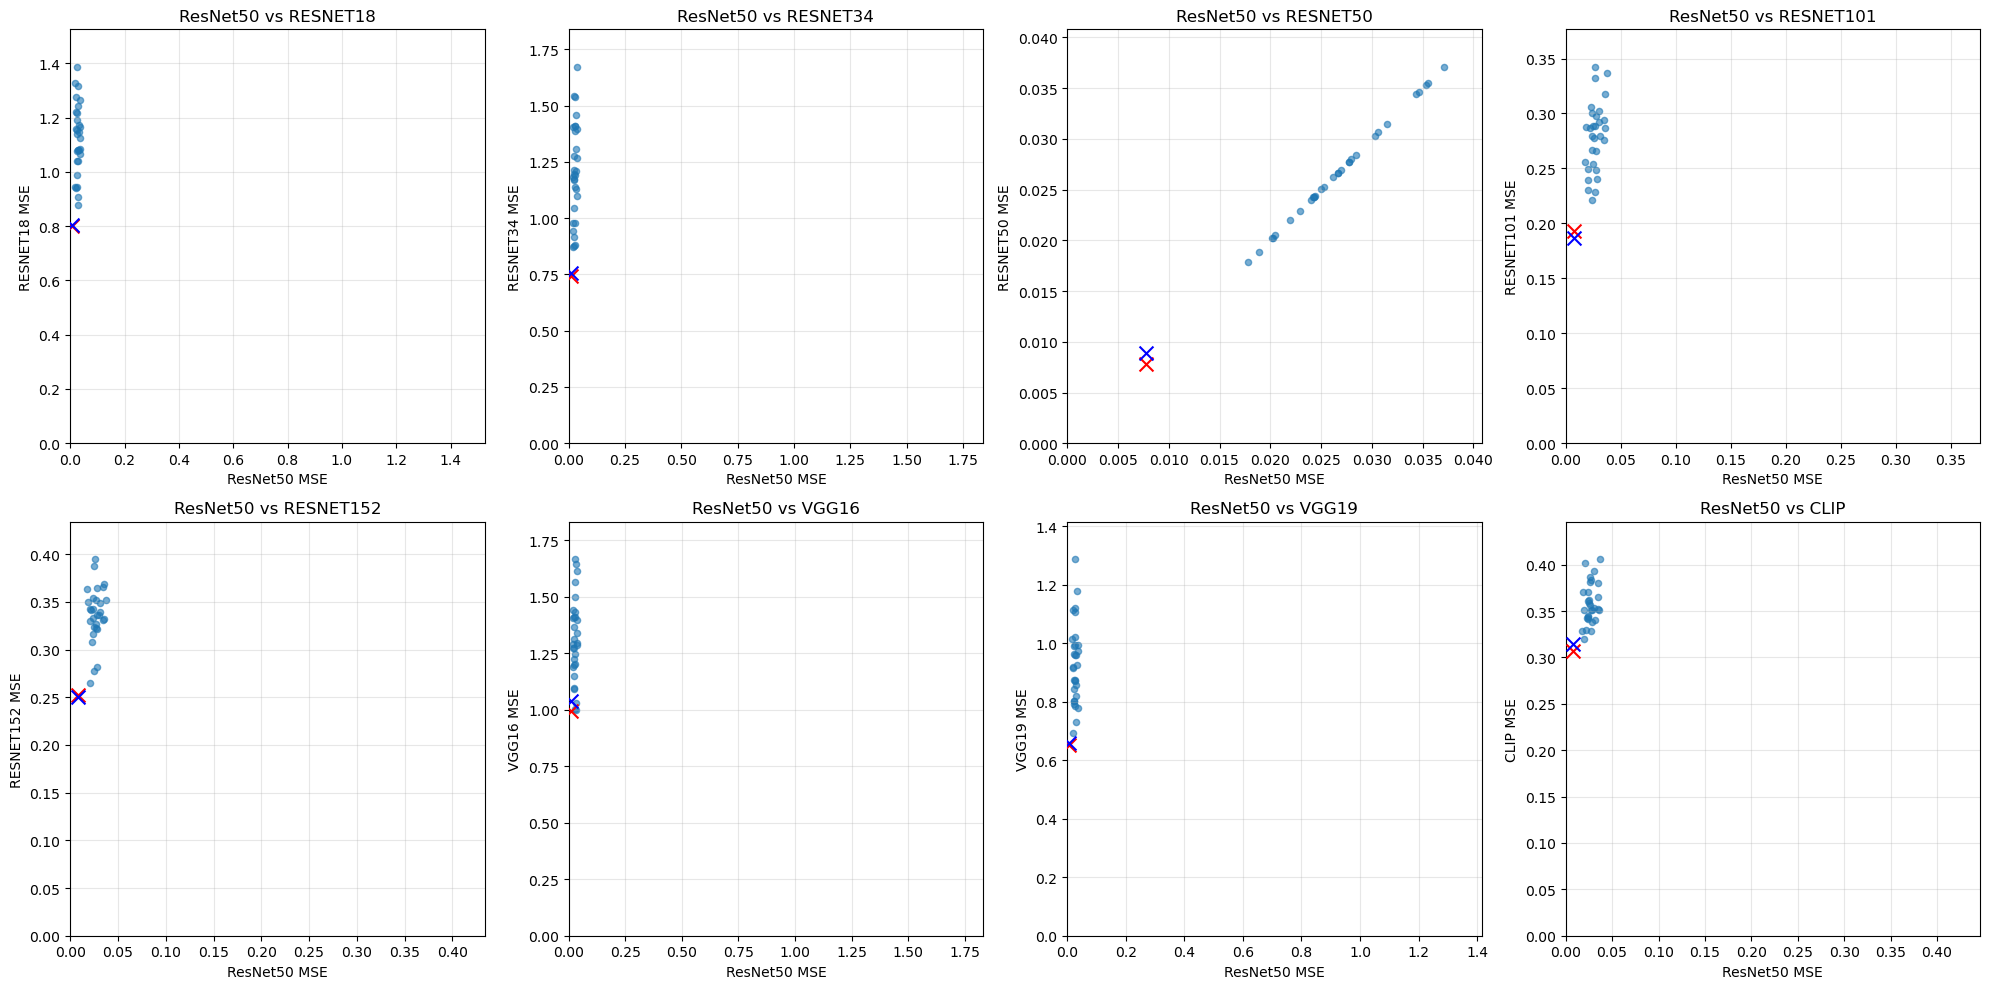

In [11]:
lfig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('MSE to ground truth embedding', fontsize=16)


resnet_avg_dist = ((clean_embeddings['resnet50'] - reconstruction_avgs['resnet50'])**2).mean()
resnet_avg_dist_half = ((clean_embeddings['resnet50'] - reconstruction_avgs_half['resnet50'])**2).mean()
for i, model in enumerate(networks.keys()):
    row = i // 4
    col = i % 4

    scatter = axes[row, col].scatter(reconstruction_distances['resnet50'], reconstruction_distances[model], alpha=0.6, s=20)
    averaged_distance = ((clean_embeddings[model] - reconstruction_avgs[model])**2).mean()
    averaged_distance_half = ((clean_embeddings[model] - reconstruction_avgs_half[model])**2).mean()
    axes[row, col].scatter(resnet_avg_dist, averaged_distance, color='red', s=100, marker='x', label='Average', zorder=5)
    axes[row, col].scatter(resnet_avg_dist, averaged_distance_half, color='blue', s=100, marker='x', label='Average (First Half)', zorder=5)
    axes[row, col].set_xlabel('ResNet50 MSE')
    axes[row, col].set_ylabel(f'{model.upper()} MSE')
    axes[row, col].set_title(f'ResNet50 vs {model.upper()}')
    axes[row, col].grid(True, alpha=0.3)
    # Set equal axis limits that include (0,0)
    max_val = max(reconstruction_distances['resnet50'].max(), reconstruction_distances[model].max())
    axes[row, col].set_xlim(0, max_val * 1.1)
    axes[row, col].set_ylim(0, max_val * 1.1)
plt.tight_layout()
plt.show()

## Distribution Shift

initing networks without ReLU


Computing embeddings for reconstructions: 100%|██████████| 30/30 [00:02<00:00, 13.55it/s]


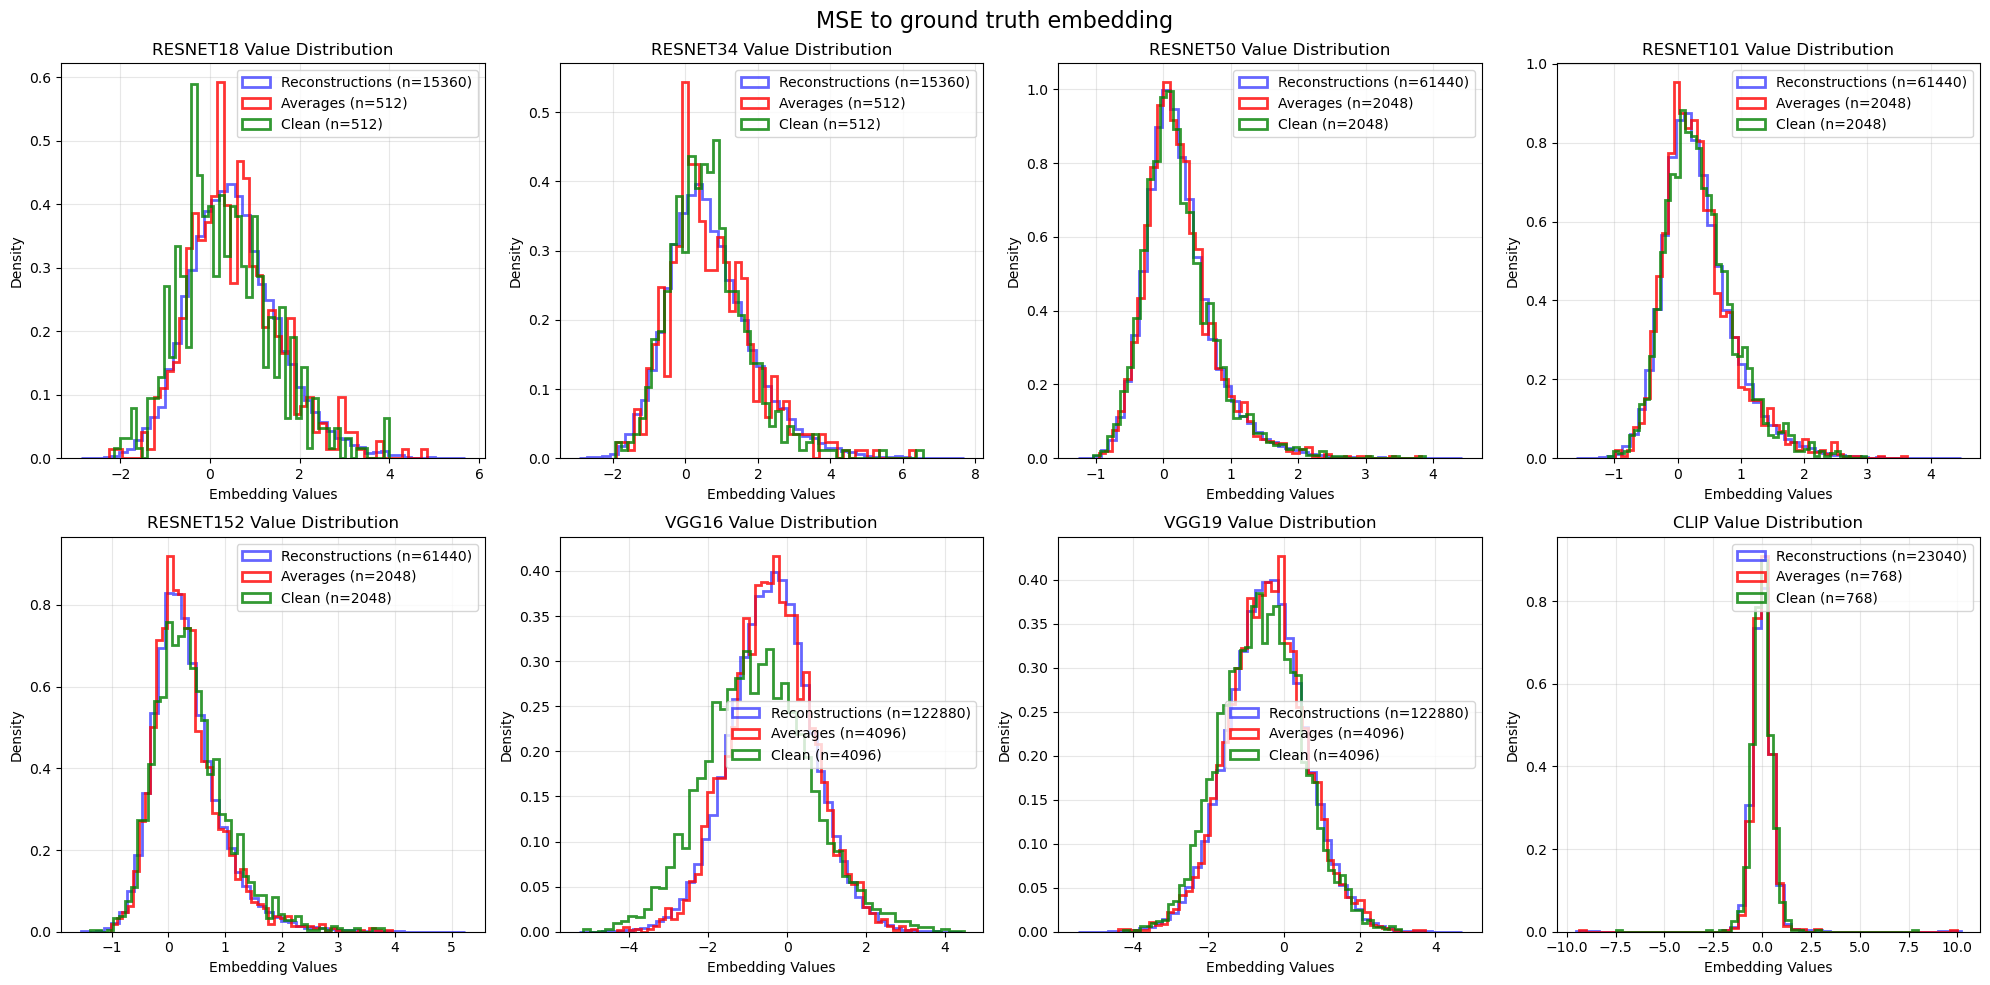

In [21]:
networks = init_networks(no_relu=True)
calc_clean_embeddings()
calc_reconstruction_embeddings()

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('MSE to ground truth embedding', fontsize=16)

bin_cnt = 50
resnet_avg_dist = ((clean_embeddings['resnet50'] - reconstruction_avgs['resnet50'])**2).mean()
for i, model in enumerate(networks.keys()):
    row = i // 4
    col = i % 4
    # Create overlapping histograms for value distributions
    ax = axes[row, col]

    all_values = reconstruction_embeddings[model].flatten()
    avg_values = reconstruction_avgs[model].flatten()
    avg_values = (avg_values - avg_values.mean()) / avg_values.std() * reconstruction_embeddings[model].std() + avg_values.mean()
    clean_values = clean_embeddings[model].flatten()

    # Count entries for labels
    n_reconstructions = len(all_values)
    n_averages = len(avg_values)
    n_clean = len(clean_values)


    ax.hist(all_values, bins=bin_cnt, alpha=0.6, density=True, label=f'Reconstructions (n={n_reconstructions})', color='blue', histtype='step', linewidth=2)
    ax.hist(avg_values, bins=bin_cnt, alpha=0.8, density=True, label=f'Averages (n={n_averages})', color='red', histtype='step', linewidth=2)
    ax.hist(clean_values, bins=bin_cnt, alpha=0.8, density=True, label=f'Clean (n={n_clean})', color='green', histtype='step', linewidth=2)

    ax.set_xlabel('Embedding Values')
    ax.set_ylabel('Density')
    ax.set_title(f'{model.upper()} Value Distribution')
    ax.grid(True, alpha=0.3)
    ax.legend()

    
plt.tight_layout()
plt.show()

initing networks with ReLU


Computing embeddings for reconstructions: 100%|██████████| 30/30 [00:02<00:00, 13.98it/s]


initing networks without ReLU


Computing embeddings for reconstructions: 100%|██████████| 30/30 [00:02<00:00, 14.37it/s]


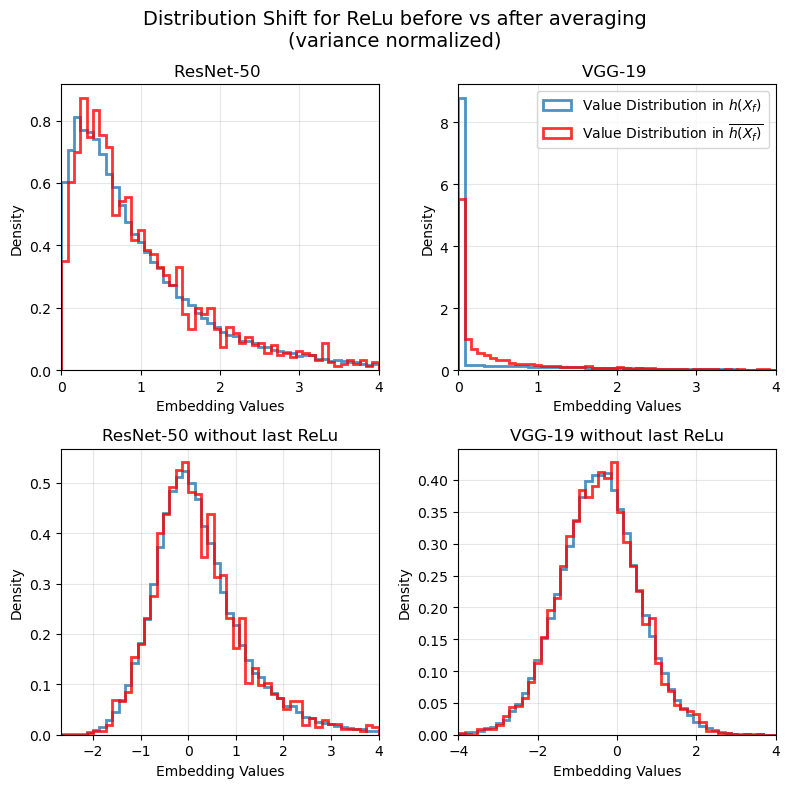

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
normalize_variance = True
fig.suptitle('Distribution Shift for ReLu before vs after averaging' + ('\n(variance normalized)' if normalize_variance else ''), fontsize=14)

def fill_row(row):
    bin_cnt = 50
    for i, model in enumerate(['resnet50', 'vgg19']):
        col = i % 2
        # Create overlapping histograms for value distributions
        ax = axes[row, col]

        if row == 0:
            all_values = (reconstruction_embeddings[model].flatten())
            avg_values = reconstruction_avgs[model].flatten()
            if normalize_variance:
                all_values = (all_values / all_values.std()) - all_values.min()
                avg_values = (avg_values) / avg_values.std() - avg_values.min()
        else:
            all_values = reconstruction_embeddings[model].flatten()
            avg_values = reconstruction_avgs[model].flatten()
            if normalize_variance:
                all_values = (all_values.flatten() - all_values.mean()) / all_values.std() + all_values.mean()
                avg_values = (avg_values - avg_values.mean()) / avg_values.std() + avg_values.mean()


        displayed_val_range = (max(all_values.min(), -4), 4)
        bins = np.linspace(*displayed_val_range, bin_cnt + 1)
        
        ax.hist(all_values, bins=bins, alpha=0.8, density=True, label=r'Value Distribution in $h(X_f)$', histtype='step', linewidth=2)
        ax.hist(avg_values, bins=bins, alpha=0.8, density=True, label=r'Value Distribution in $\overline{h(X_f)}$', color='red', histtype='step', linewidth=2)

        ax.set_xlabel('Embedding Values')
        ax.set_ylabel('Density')
        ax.set_xlim(displayed_val_range)
        ax.set_title(f'{display_name[model]} ' + ('without last ReLu' if row == 1 else ''))
        ax.grid(True, alpha=0.3)
        if row == 0 and col == 1:
            ax.legend()

networks = init_networks(False)
calc_clean_embeddings()
calc_reconstruction_embeddings()
fill_row(0)
networks = init_networks(True)
calc_clean_embeddings()
calc_reconstruction_embeddings()
fill_row(1)

    
plt.tight_layout()
plt.show()

fig.savefig('out/figures/relu-norelu-distribution-shift.pdf', bbox_inches='tight')